C:\Users\MSI GF63\AppData\Local\Temp\ipykernel_15872\3095839448.py:152: RuntimeWarning: invalid value encountered in double_scalars
  speech_ratio = sum_voice_energy/sum_full_energy


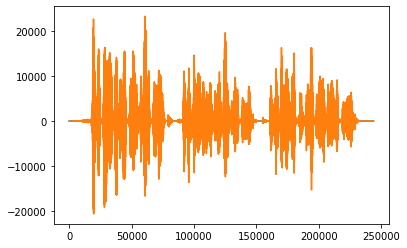

C:\Users\MSI GF63\AppData\Local\Temp\ipykernel_15872\3095839448.py:152: RuntimeWarning: invalid value encountered in double_scalars
  speech_ratio = sum_voice_energy/sum_full_energy


2880.0 0.18
32000.0 2.0
32800.0 2.05
35200.0 2.2
35520.0 2.22
47040.0 2.94
48480.0 3.03
112800.0 7.05
113120.0 7.07
139040.0 8.69
140960.0 8.81
144480.0 9.03
145920.0 9.12
233440.0 14.59
[{'speech_begin': 0.18, 'speech_end': 2.0}, {'speech_begin': 2.05, 'speech_end': 2.2}, {'speech_begin': 2.22, 'speech_end': 2.94}, {'speech_begin': 3.03, 'speech_end': 7.05}, {'speech_begin': 7.07, 'speech_end': 8.69}, {'speech_begin': 8.81, 'speech_end': 9.03}, {'speech_begin': 9.12, 'speech_end': 14.59}]


In [36]:
import numpy as np
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt

class VoiceActivityDetector():
    """ Use signal energy to detect voice activity in wav file """
    
    def __init__(self, wave_input_filename):
        self._read_wav(wave_input_filename)._convert_to_mono()
        self.sample_window = 0.02 #20 ms
        self.sample_overlap = 0.01 #10ms
        self.speech_window = 0.5 #half a second
        self.speech_energy_threshold = 0.2 #60% of energy in voice band
        self.speech_start_band = 300
        self.speech_end_band = 3000
           
    def _read_wav(self, wave_file):
        
        self.rate, self.data = wf.read(wave_file)
        # self.data=self.data/max(abs(self.data))
        self.channels = len(self.data.shape)
        self.filename = wave_file

        return self
    
    def _convert_to_mono(self):
        if self.channels == 2 :
            self.data = np.mean(self.data, axis=1, dtype=self.data.dtype)
            self.channels = 1
        return self
    
    def _calculate_frequencies(self, audio_data):
        data_freq = np.fft.fftfreq(len(audio_data),1.0/self.rate)
        data_freq = data_freq[1:]
        return data_freq    
    
    def _calculate_amplitude(self, audio_data):
        data_ampl = np.abs(np.fft.fft(audio_data))
        data_ampl = data_ampl[1:]
        return data_ampl
        
    def _calculate_energy(self, data):
        data_amplitude = self._calculate_amplitude(data)
        data_energy = data_amplitude ** 2
        return data_energy
        
    def _znormalize_energy(self, data_energy):
        energy_mean = np.mean(data_energy)
        energy_std = np.std(data_energy)
        energy_znorm = (data_energy - energy_mean) / energy_std
        return energy_znorm
    
    def _connect_energy_with_frequencies(self, data_freq, data_energy):
        energy_freq = {}
        for (i, freq) in enumerate(data_freq):
            if abs(freq) not in energy_freq:
                energy_freq[abs(freq)] = data_energy[i] * 2
        return energy_freq
    
    def _calculate_normalized_energy(self, data):
        data_freq = self._calculate_frequencies(data)
        data_energy = self._calculate_energy(data)
        #data_energy = self._znormalize_energy(data_energy) #znorm brings worse results
        energy_freq = self._connect_energy_with_frequencies(data_freq, data_energy)
        return energy_freq
    
    def _sum_energy_in_band(self,energy_frequencies, start_band, end_band):
        sum_energy = 0
        for f in energy_frequencies.keys():
            if start_band<f<end_band:
                sum_energy += energy_frequencies[f]
        return sum_energy
    
    def _median_filter (self, x, k):
        assert k % 2 == 1, "Median filter length must be odd."
        assert x.ndim == 1, "Input must be one-dimensional."
        k2 = (k - 1) // 2
        y = np.zeros ((len (x), k), dtype=x.dtype)
        y[:,k2] = x
        for i in range (k2):
            j = k2 - i
            y[j:,i] = x[:-j]
            y[:j,i] = x[0]
            y[:-j,-(i+1)] = x[j:]
            y[-j:,-(i+1)] = x[-1]
        return np.median (y, axis=1)
        
    def _smooth_speech_detection(self, detected_windows):
        median_window=int(self.speech_window/self.sample_window)
        if median_window%2==0: median_window=median_window-1
        median_energy = self._median_filter(detected_windows[:,1], median_window)
        return median_energy
        
    def convert_windows_to_readible_labels(self, detected_windows):
        """ Takes as input array of window numbers and speech flags from speech
        detection and convert speech flags to time intervals of speech.
        Output is array of dictionaries with speech intervals.
        """
        speech_time = []
        is_speech = 0
        for window in detected_windows:
            if (window[1]==1.0 and is_speech==0): 
                is_speech = 1
                speech_label = {}
                speech_time_start = window[0] / self.rate
                speech_label['speech_begin'] = speech_time_start
                print(window[0], speech_time_start)
                #speech_time.append(speech_label)
            if (window[1]==0.0 and is_speech==1):
                is_speech = 0
                speech_time_end = window[0] / self.rate
                speech_label['speech_end'] = speech_time_end
                speech_time.append(speech_label)
                print(window[0], speech_time_end)
        return speech_time
      
    def plot_detected_speech_regions(self):
        """ Performs speech detection and plot original signal and speech regions.
        """
        data = self.data
        detected_windows = self.detect_speech()
        data_speech = np.zeros(len(data))
        it = np.nditer(detected_windows[:,0], flags=['f_index'])
        while not it.finished:
            data_speech[int(it[0])] = data[int(it[0])] * detected_windows[it.index,1]
            it.iternext()
        plt.figure()
        plt.plot(data_speech)
        plt.plot(data)
        plt.show()
        return self
       
    def detect_speech(self):
        """ Detects speech regions based on ratio between speech band energy
        and total energy.
        Output is array of window numbers and speech flags (1 - speech, 0 - nonspeech).
        """
        detected_windows = np.array([])
        sample_window = int(self.rate * self.sample_window)
        sample_overlap = int(self.rate * self.sample_overlap)
        data = self.data
        sample_start = 0
        start_band = self.speech_start_band
        end_band = self.speech_end_band
        while (sample_start < (len(data) - sample_window)):
            sample_end = sample_start + sample_window
            if sample_end>=len(data): sample_end = len(data)-1
            data_window = data[sample_start:sample_end]
            energy_freq = self._calculate_normalized_energy(data_window)
            sum_voice_energy = self._sum_energy_in_band(energy_freq, start_band, end_band)
            sum_full_energy = sum(energy_freq.values())
            speech_ratio = sum_voice_energy/sum_full_energy
            # Hipothesis is that when there is a speech sequence we have ratio of energies more than Threshold
            speech_ratio = speech_ratio>self.speech_energy_threshold
            detected_windows = np.append(detected_windows,[sample_start, speech_ratio])
            sample_start += sample_overlap
        detected_windows = detected_windows.reshape(int(len(detected_windows)/2),2)
        detected_windows[:,1] = self._smooth_speech_detection(detected_windows)
        return detected_windows
        

filename = 'C:/Users/MSI GF63/Desktop/P2M/VAD-python-master/train_150.wav'

v = VoiceActivityDetector(filename)
v.plot_detected_speech_regions()
raw_detection = v.detect_speech()
speech_labels = v.convert_windows_to_readible_labels(raw_detection)
print(speech_labels)



# load audio


In [11]:
train_149_file = "train_149.wav"
ipd.Audio(train_149_file)


NameError: name 'ipd' is not defined

In [3]:
train_150_file = "C:/Users/MSI GF63/Desktop/P2M/wav/train_150.wav"
ipd.Audio(train_150_file)

In [4]:
train_150 ,sr = librosa.load(train_150_file)
train_149 ,sr = librosa.load(train_149_file)

In [5]:
train_150.shape

(336042,)

In [6]:
train_150.size

336042

# duration of a sample

In [7]:

sample_duration=1/sr
print(f"duration of a sample is :{sample_duration:6f}seconds")

duration of a sample is :0.000045seconds


# duration of a signal

In [26]:

duration = sample_duration * len(train_150)
print(f"duration of signale is :{duration:6f}seconds")

duration of signale is :15.240000seconds


# visualise the wave form


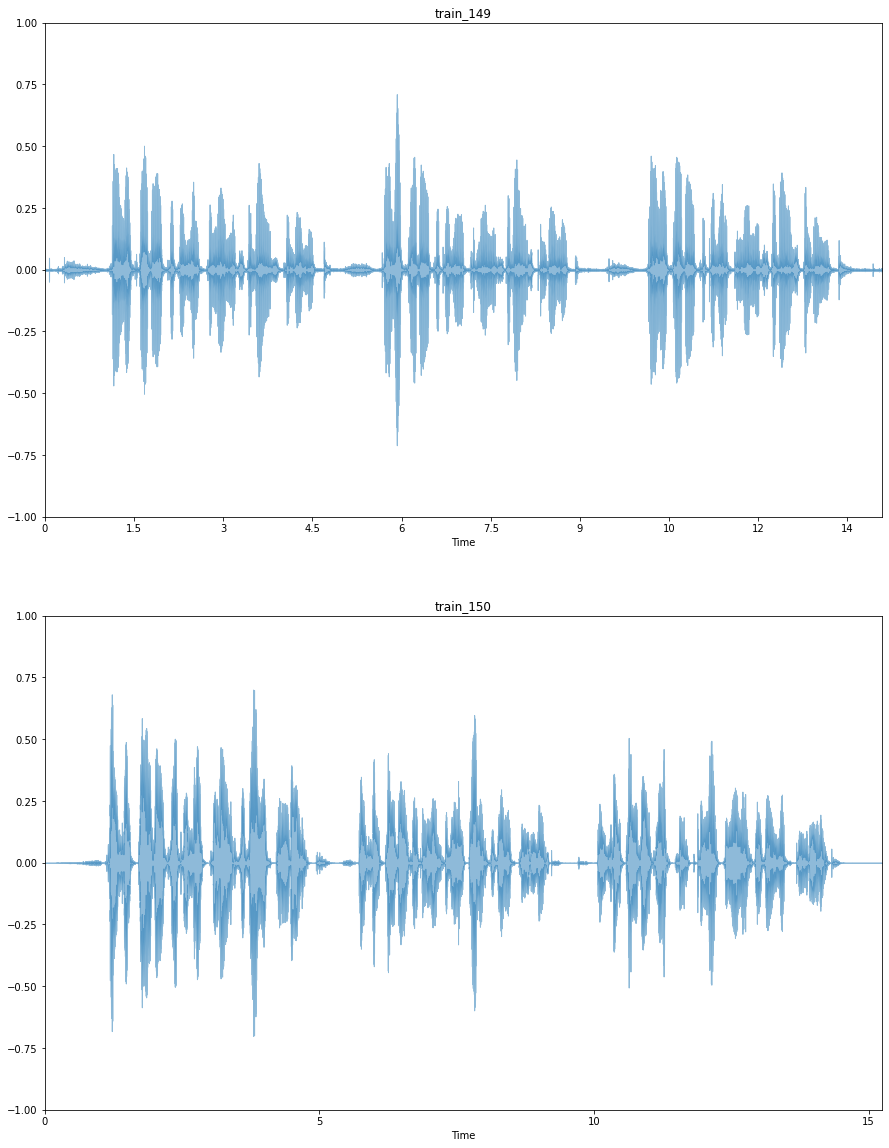

In [27]:

plt.figure(figsize=(15,20))

plt.subplot(2,1,1)
librosa.display.waveplot(train_149,alpha=0.5)
plt.title("train_149")
plt.ylim((-1,1))

plt.subplot(2,1,2)
librosa.display.waveplot(train_150,alpha=0.5)
plt.title("train_150")
plt.ylim((-1,1))

plt.show()

# calculate the amplitude enveloppe



In [28]:
FRAME_SIZE=1024
HOP_LENGTH=512
def amp_env(signal,frame_size,hop_length):
    return np.array([max(signal[i:i+frame_size])for i in range (0, signal.size ,hop_length)])

In [31]:
ae_149=amp_env(train_149,FRAME_SIZE,HOP_LENGTH)
len(ae_149)

607

In [32]:
ae_150=amp_env(train_150,FRAME_SIZE,HOP_LENGTH)
len(ae_150)


657

# vis amplitude_env


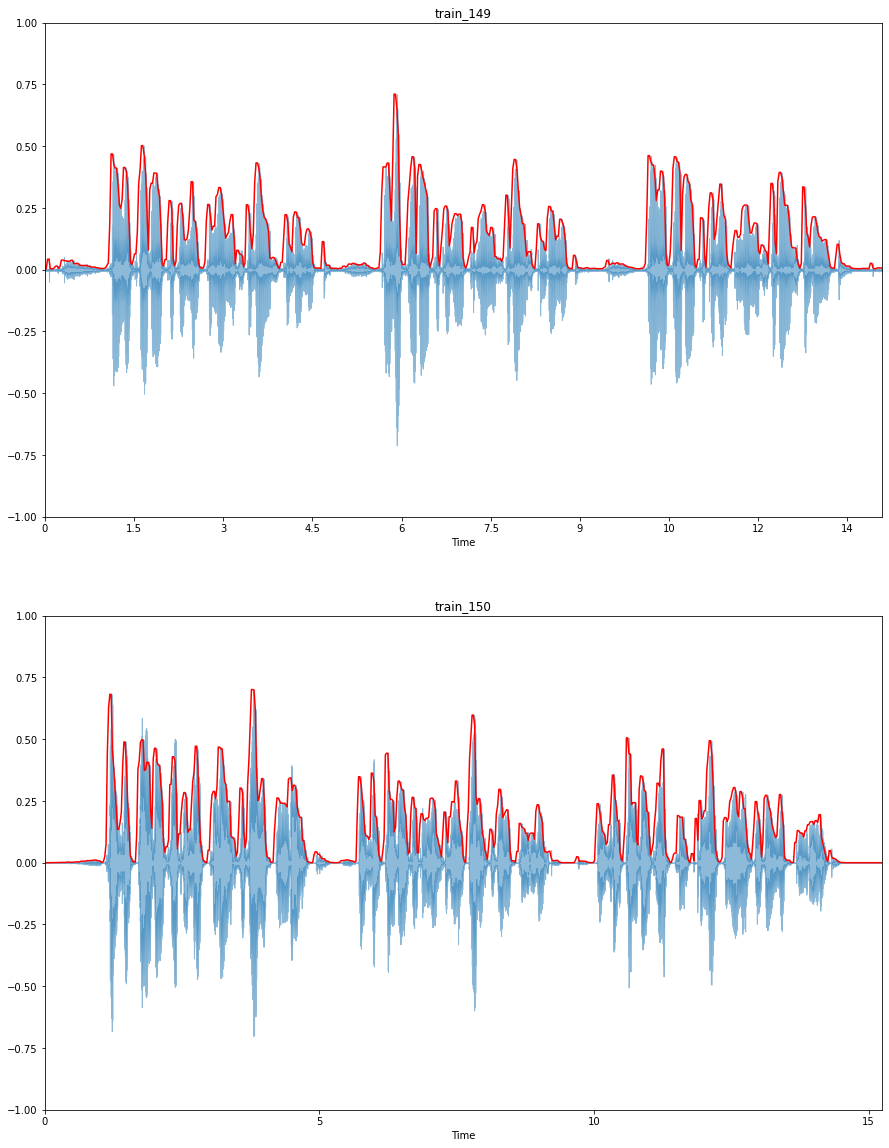

In [33]:

frames1 = range(0,ae_149.size)
t1=librosa.frames_to_time(frames1,hop_length=HOP_LENGTH)

plt.figure(figsize=(15,20))

plt.subplot(2,1,1)
librosa.display.waveplot(train_149,alpha=0.5)
plt.plot(t1,ae_149,color="r")
plt.title("train_149")
plt.ylim((-1,1))

frames2 = range(0,ae_150.size)
t2=librosa.frames_to_time(frames2,hop_length=HOP_LENGTH)
plt.subplot(2,1,2)
librosa.display.waveplot(train_150,alpha=0.5)
plt.plot(t2,ae_150,color="r")
plt.title("train_150")
plt.ylim((-1,1))

plt.show()

In [34]:
 FRAME_LENGTH=1024

In [35]:
rms_train_149=librosa.feature.rms(train_149,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
rms_train_150=librosa.feature.rms(train_150,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]

In [36]:
rms_train_149.shape

(607,)

# plot rms feature with librsa


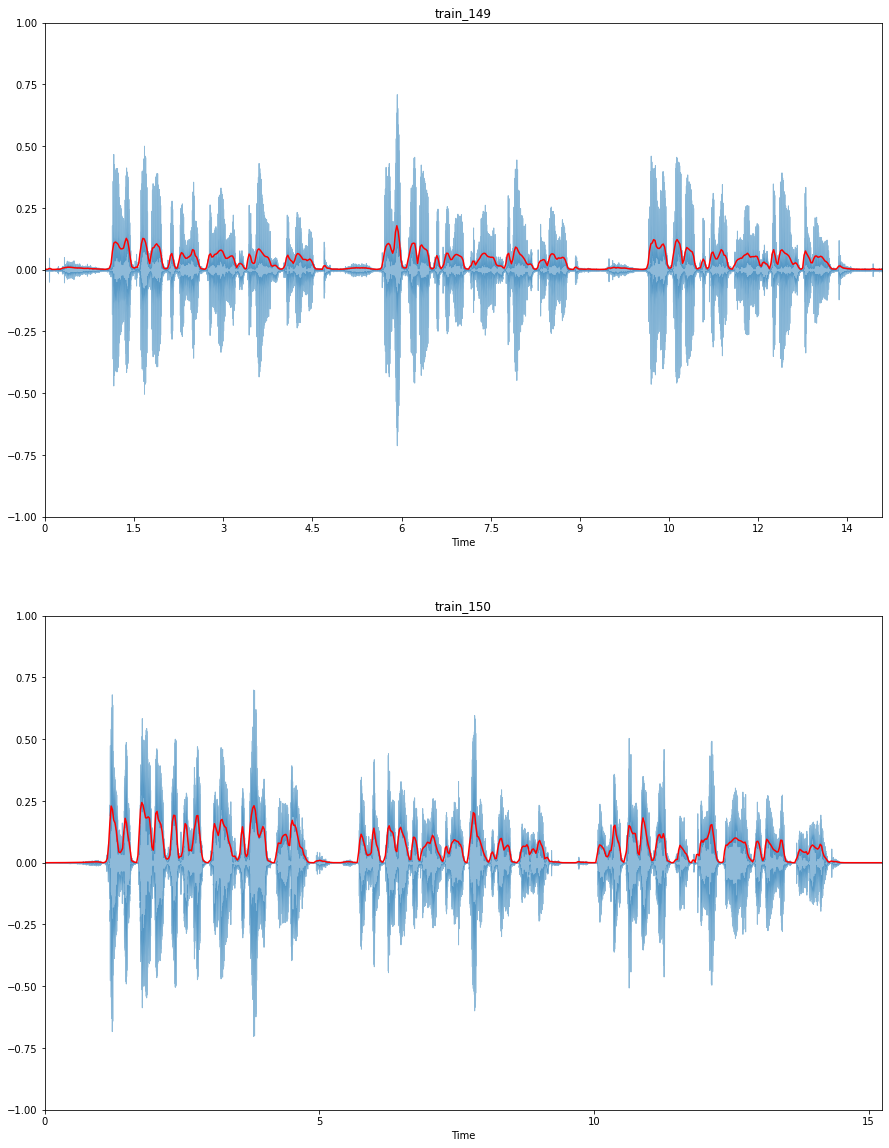

In [37]:

frames1 = range(len(rms_train_149))
t1=librosa.frames_to_time(frames1,hop_length=HOP_LENGTH)

plt.figure(figsize=(15,20))

plt.subplot(2,1,1)
librosa.display.waveplot(train_149,alpha=0.5)
plt.plot(t1,rms_train_149,color="r")
plt.title("train_149")
plt.ylim((-1,1))

frames2 = range(len(rms_train_150))
t2=librosa.frames_to_time(frames2,hop_length=HOP_LENGTH)
plt.subplot(2,1,2)
librosa.display.waveplot(train_150,alpha=0.5)
plt.plot(t2,rms_train_150,color="r")
plt.title("train_150")
plt.ylim((-1,1))

plt.show()

In [38]:
def rms(signal,frame_length,hop_length):
    rms=[]
    for i in range(0,len(signal),hop_length):
        rms_current_frame=np.sqrt(np.sum(signal[i:i+frame_length]**2)/frame_length)
        rms.append(rms_current_frame)
        
    return np.array(rms)
    

In [39]:
rms1_train_149=rms(train_149,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)
rms1_train_150=rms(train_150,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)

# plot rms feature with function

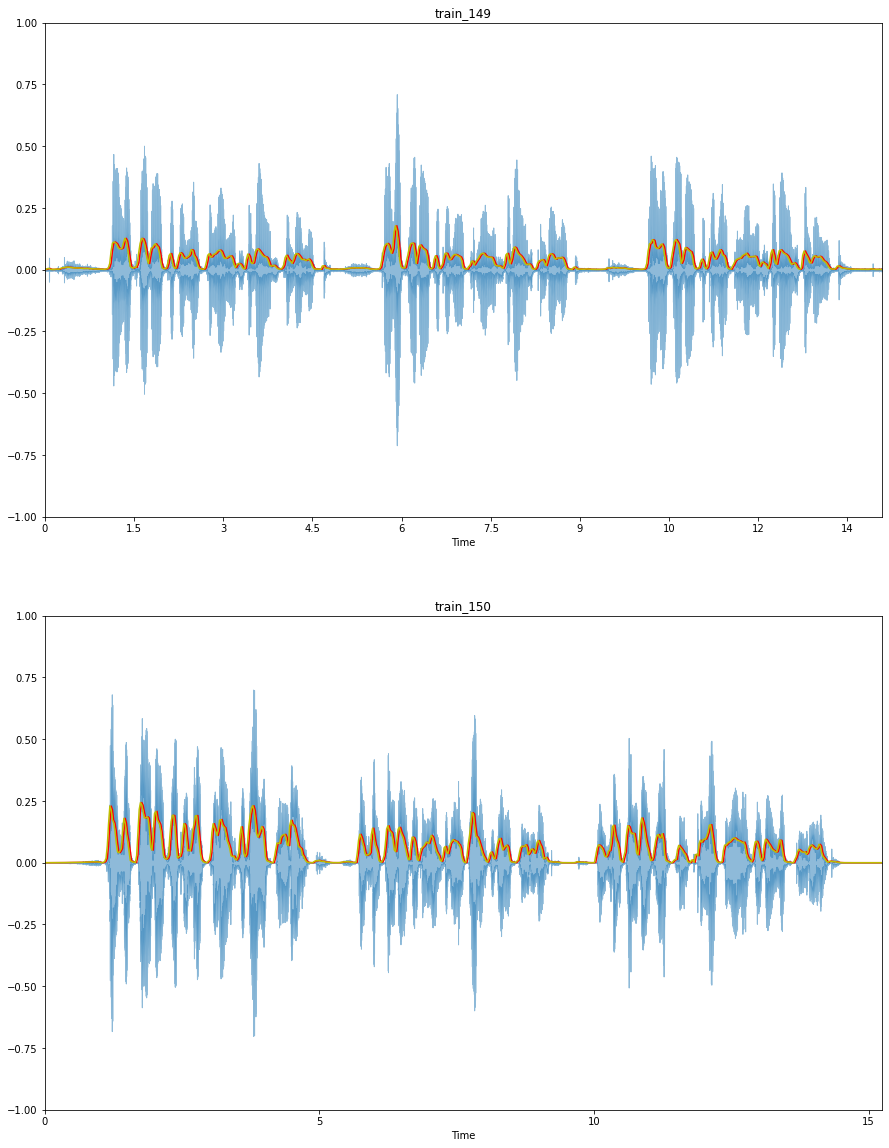

In [40]:


frames1 = range(len(rms_train_149))
t1=librosa.frames_to_time(frames1,hop_length=HOP_LENGTH)

plt.figure(figsize=(15,20))

plt.subplot(2,1,1)
librosa.display.waveplot(train_149,alpha=0.5)
plt.plot(t1,rms_train_149,color="r")
plt.plot(t1,rms1_train_149,color="y")

plt.title("train_149")
plt.ylim((-1,1))

frames2 = range(len(rms_train_150))
t2=librosa.frames_to_time(frames2,hop_length=HOP_LENGTH)
plt.subplot(2,1,2)
librosa.display.waveplot(train_150,alpha=0.5)
plt.plot(t2,rms_train_150,color="r")
plt.plot(t2,rms1_train_150,color="y")

plt.title("train_150")
plt.ylim((-1,1))

plt.show()

# zero crossing rate with librosa

In [41]:
zcr_train_149=librosa.feature.zero_crossing_rate(train_149,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
zcr_train_150=librosa.feature.zero_crossing_rate(train_150,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]

# # vis #zero crossing rate with librosa

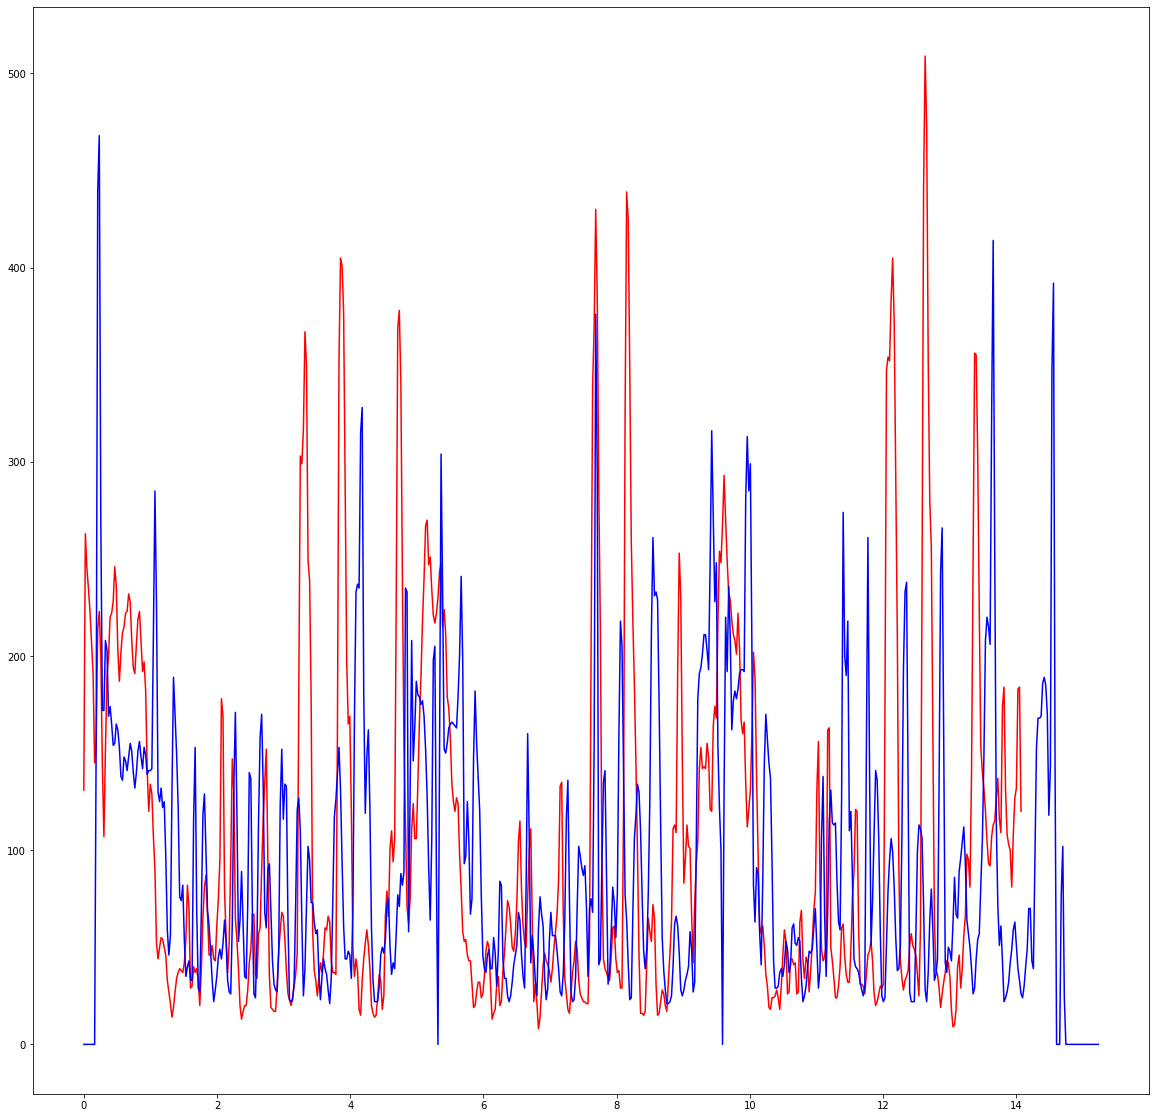

In [43]:

plt.figure(figsize=(20,20))


frames1 = range(len(zcr_train_149))
t1=librosa.frames_to_time(frames1,hop_length=HOP_LENGTH)
frames2 = range(len(zcr_train_150))
t2=librosa.frames_to_time(frames2,hop_length=HOP_LENGTH)

plt.plot(t1,zcr_train_149*FRAME_LENGTH,color="r")
plt.plot(t2,zcr_train_150*FRAME_LENGTH,color="b")



plt.show()

# noise has more zcr then useful audio

# transformer de fourier


In [44]:
train_149_ft=sp.fft.fft(train_149)
magnitude=np.absolute(train_149_ft)
freq=np.linspace(0,sr,len(magnitude))

# plot FT


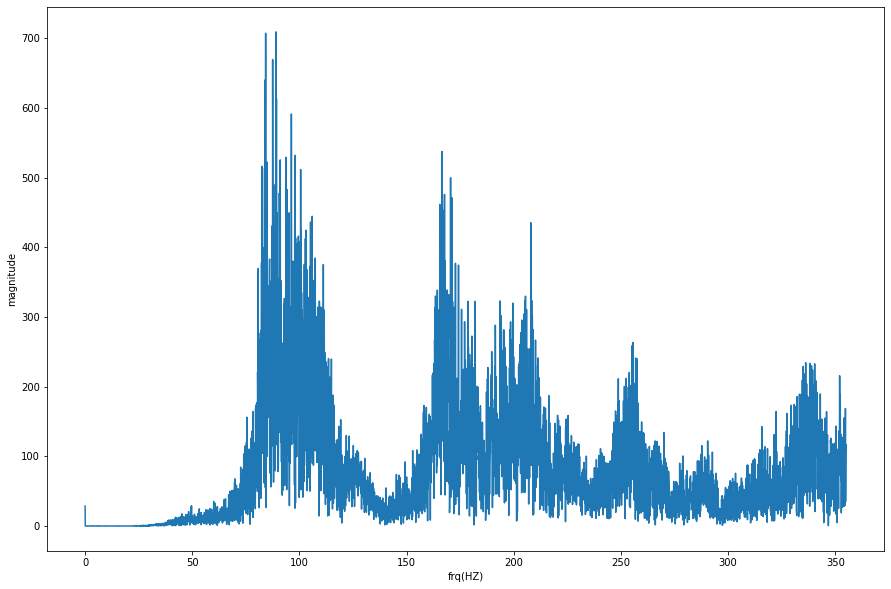

In [45]:
plt.figure(figsize=(15,10))
plt.plot(freq[:5000],magnitude[:5000])
plt.xlabel("frq(HZ)")
plt.ylabel("magnitude")
plt.show()

In [46]:
len(train_149)

310464

In [47]:
d=1/sr
d

4.5351473922902495e-05

In [48]:
d_523=1/523
d_523

0.0019120458891013384

In [49]:
train_149_ft[0]

(28.704792-0j)

In [50]:
magnitude[0]

28.704792

# plot magnitude 

In [51]:


def plot_magnitude_spectrum(signal,title,sr,f_ratio=1):
    ft=np.fft.fft(signal)
    magnitude_spectrum=np.abs(ft)
    plt.figure(figsize=(18,5))
    freq=np.linspace(0,sr,len(magnitude_spectrum))
    num_freq_bins=int(len(freq)*f_ratio)
    plt.plot(freq[:num_freq_bins],magnitude_spectrum[:num_freq_bins])
    plt.xlabel("freq(HZ)")
    plt.title(title)
    plt.show( )

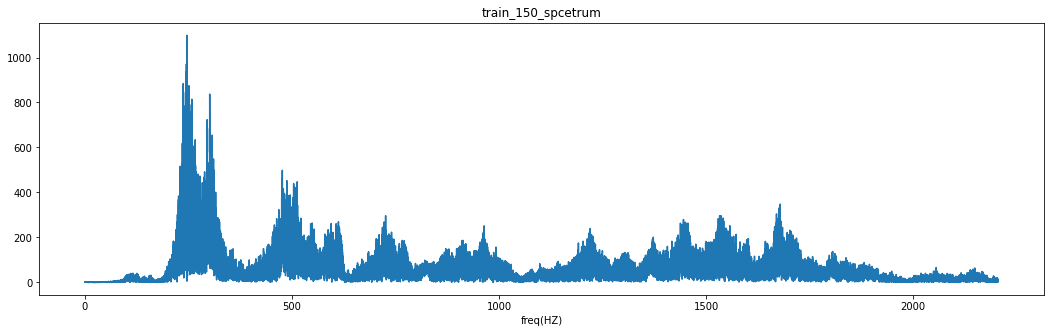

In [52]:
plot_magnitude_spectrum(train_150,"train_150_spcetrum",sr,0.1)

# short Time fourier Transform  --> spectrograms

In [53]:
FRAME_SIZE = 2048
HOP_SIZE = 512

In [54]:
S_train_149 = librosa.stft(train_149, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
S_train_149.shape


(1025, 607)

In [55]:
type(S_train_149[0][0])

numpy.complex64

In [56]:
Y_train_149=np.abs(S_train_149)

In [57]:
Y_train_149.shape

(1025, 607)

In [58]:
type(Y_train_149[0][0])

numpy.float32

# Visualizing the spectrogram


In [59]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+5.f")

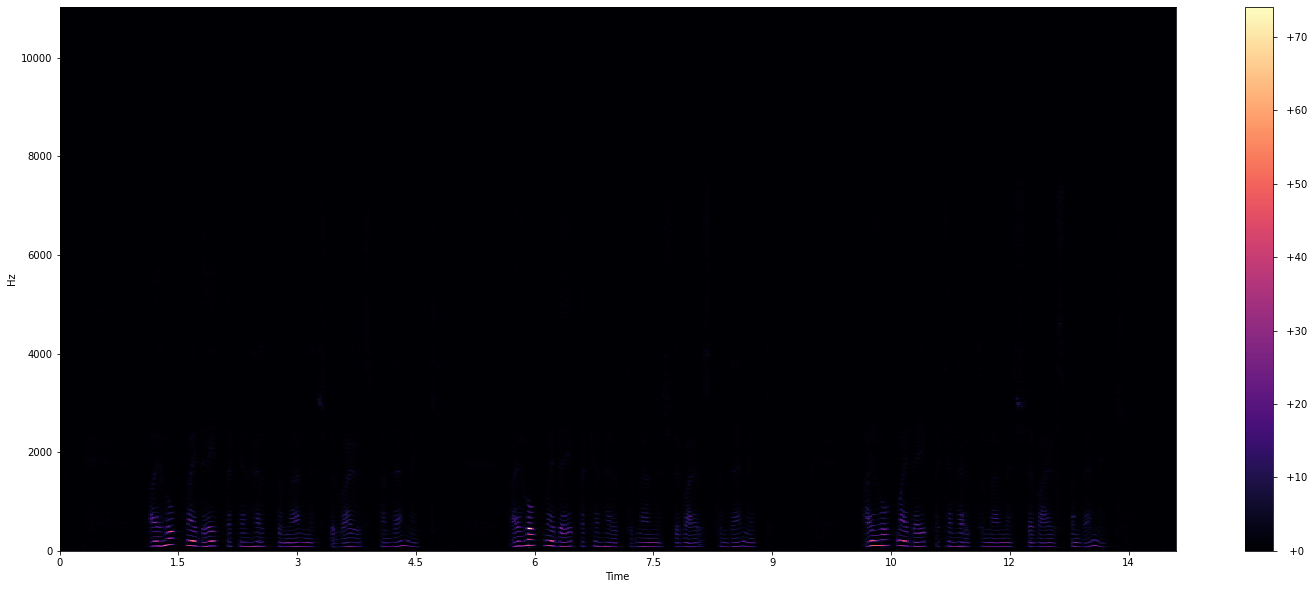

In [60]:
plot_spectrogram(Y_train_149, sr, HOP_SIZE)

# Log-Amplitude Spectrogram


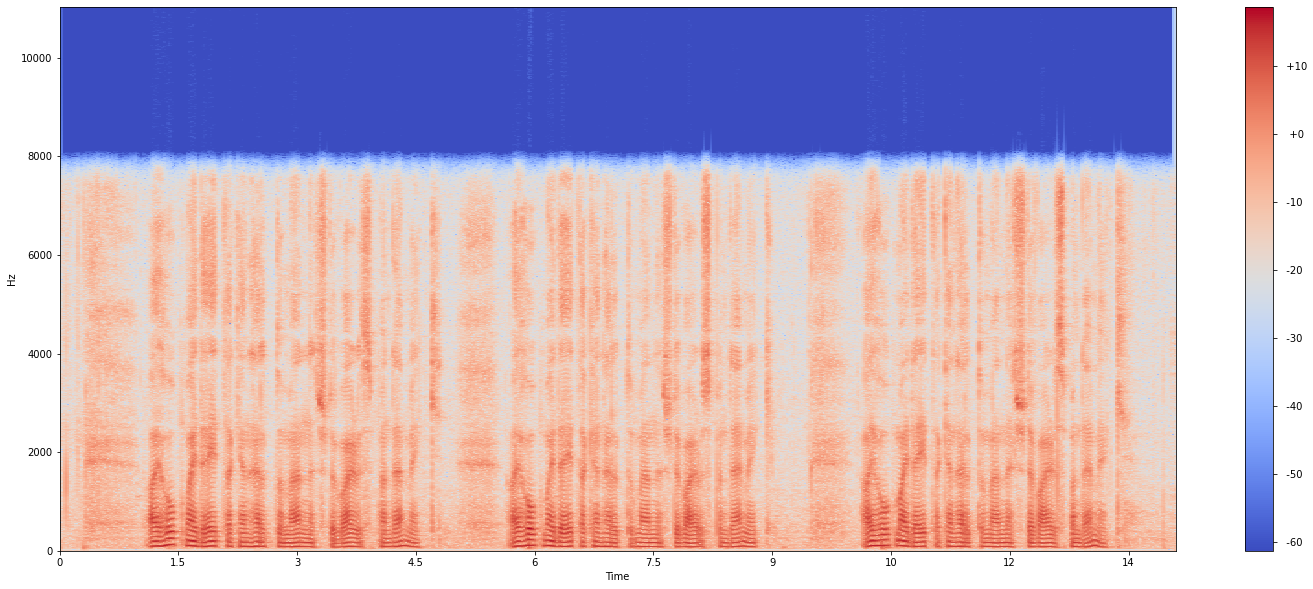

In [61]:
Y_log_train_149 = librosa.power_to_db(Y_train_149)
plot_spectrogram(Y_log_train_149, sr, HOP_SIZE)

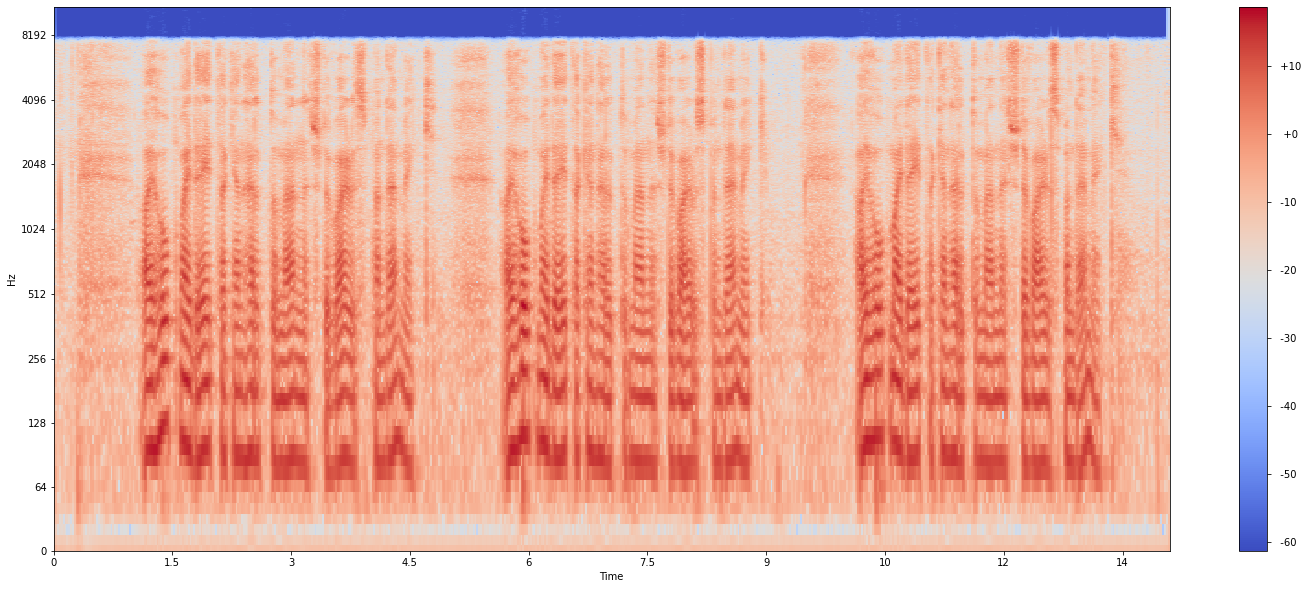

In [62]:
plot_spectrogram(Y_log_train_149, sr, HOP_SIZE, y_axis="log")


# mel_fequency ((humans perceive freq logarithmically))


# mel filter banks


In [68]:

filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)
filter_banks.shape


(10, 1025)

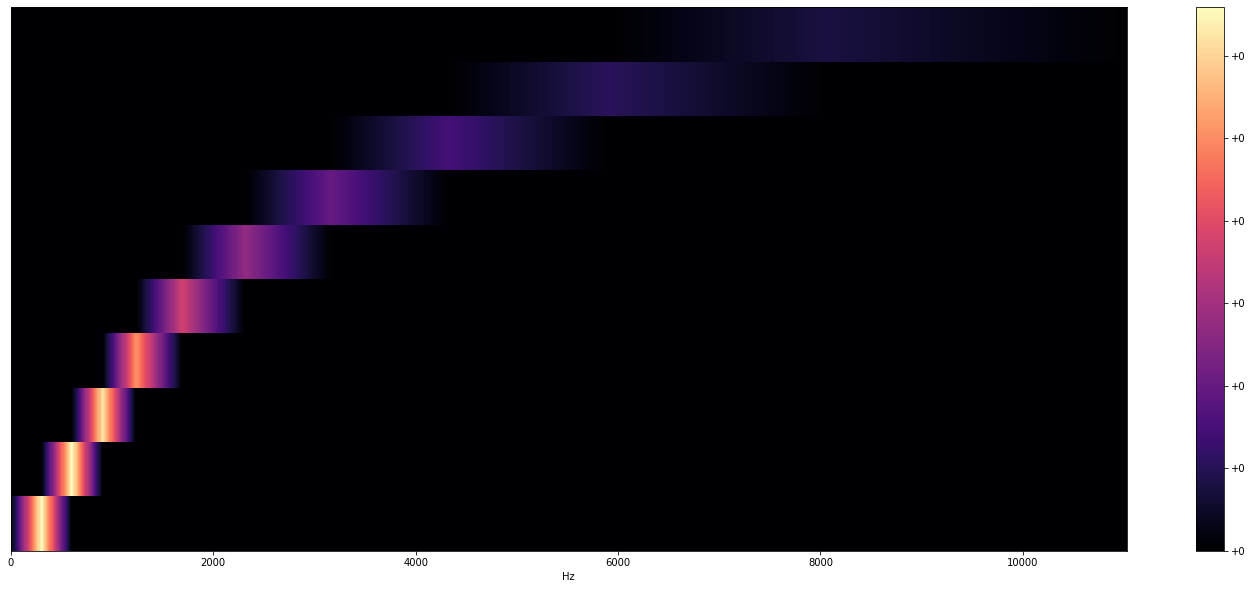

In [69]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

# Extracting Mel Spectrogram

In [70]:
mel_spectrogram = librosa.feature.melspectrogram(train_149, sr=sr, n_fft=2048, hop_length=512, n_mels=100)
mel_spectrogram.shape

(100, 607)

In [71]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
log_mel_spectrogram.shape


(100, 607)

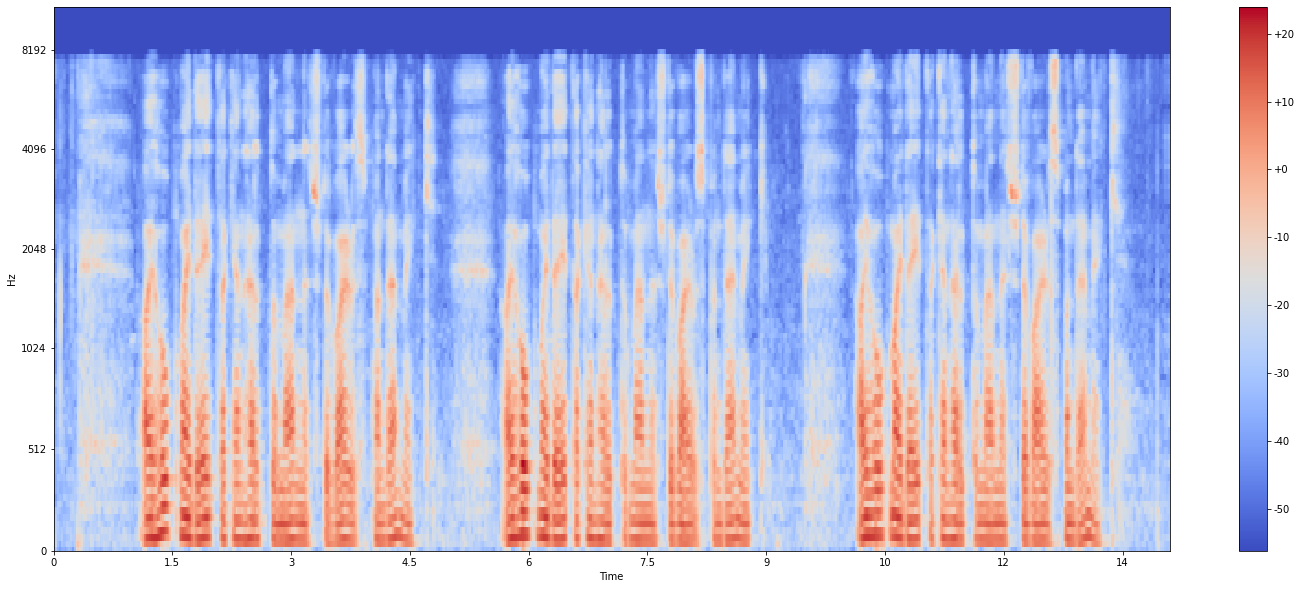

In [72]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

# MFCC :Mel-Frequency Cepstral Coefficients

In [77]:
mfccs = librosa.feature.mfcc(y=train_149, n_mfcc=13, sr=sr) 


In [78]:
mfccs.shape

(13, 607)

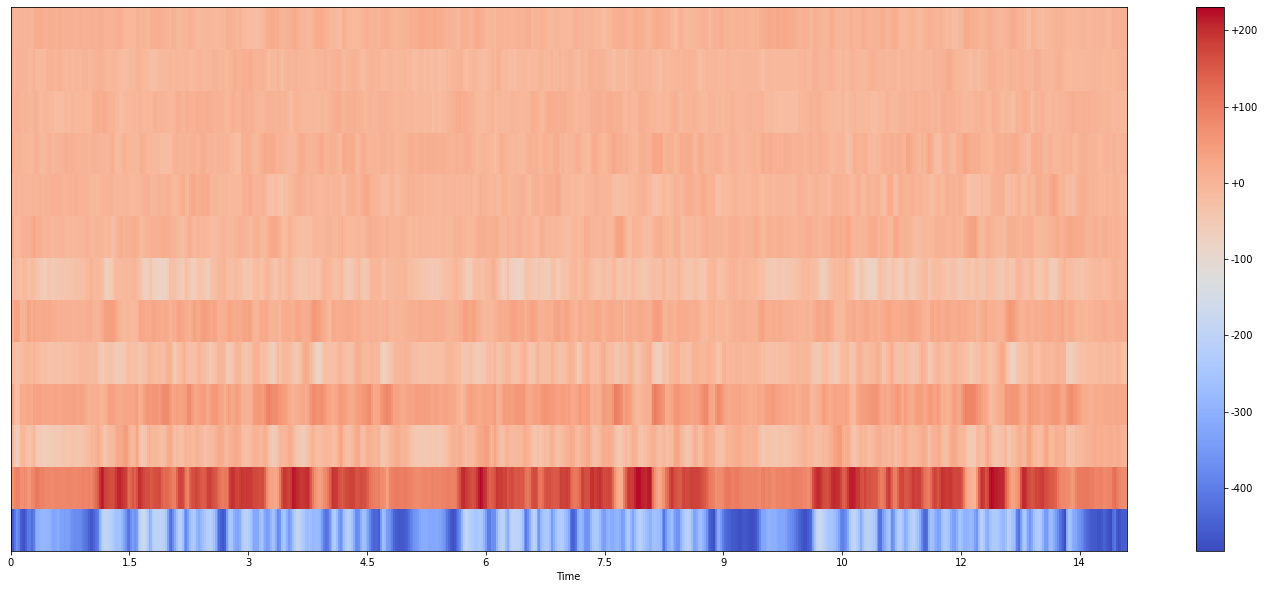

In [79]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

# Computing first / second MFCCs derivatives

In [80]:
delta_mfccs = librosa.feature.delta(mfccs)

In [81]:
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [82]:
delta_mfccs.shape

(13, 607)

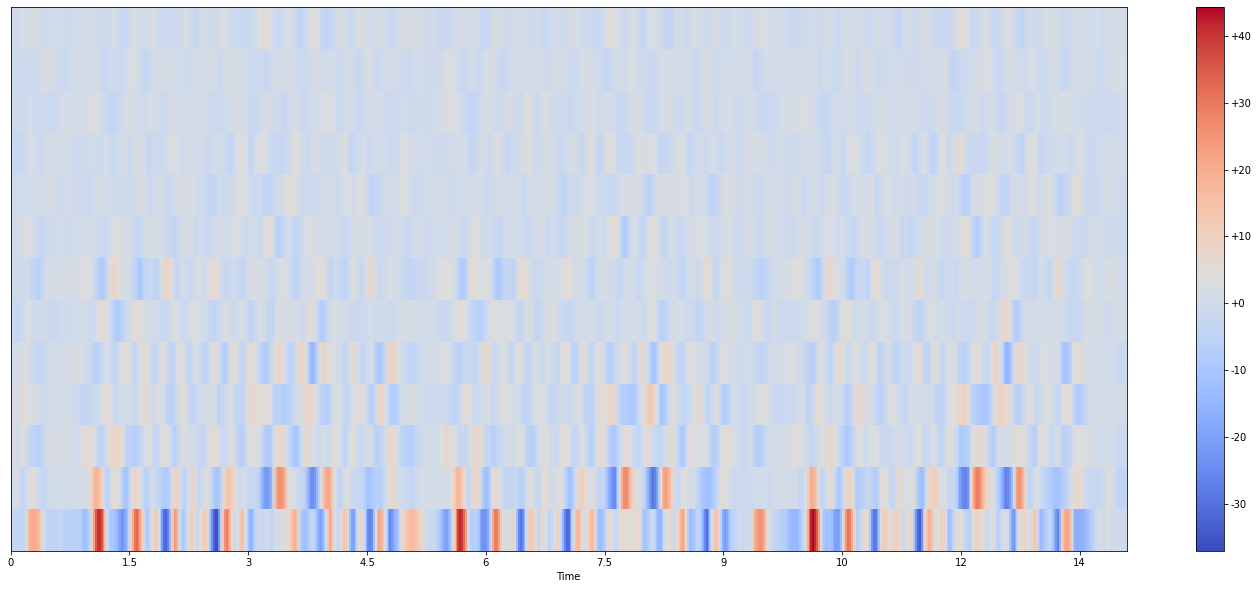

In [83]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

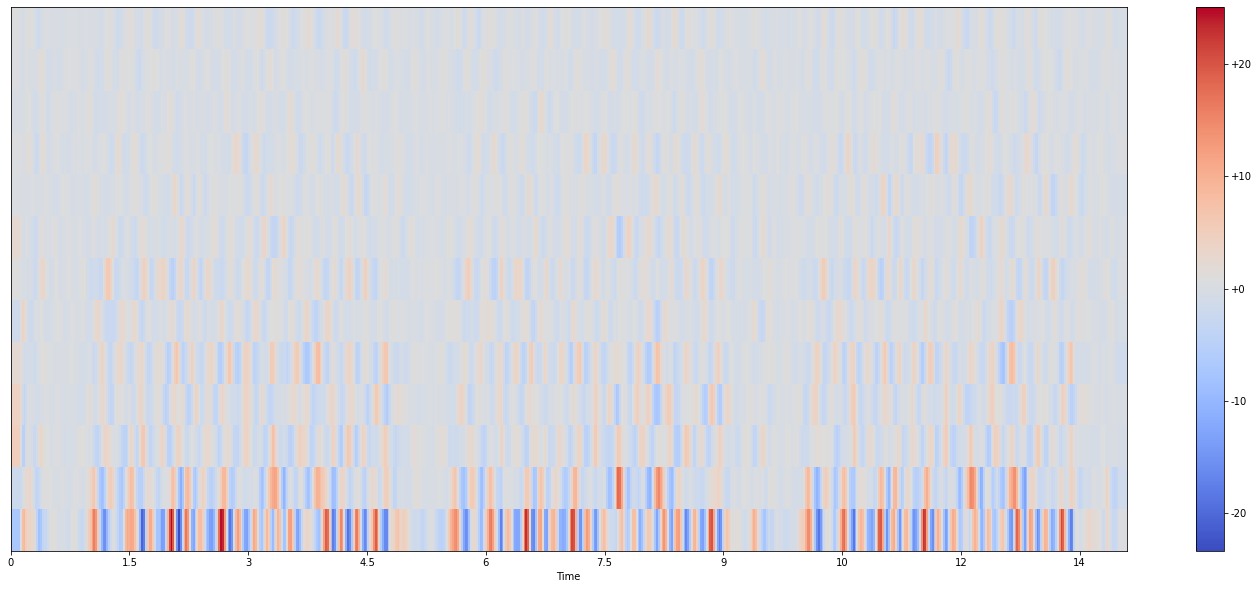

In [84]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [85]:
S_train_149.shape

(1025, 607)

# Calculate Band Energy Ratio


In [86]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [87]:
split_frequency_bin = calculate_split_frequency_bin(2000, 22050, 1025)
split_frequency_bin

185

In [88]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [89]:
ber_train_149 = band_energy_ratio(S_train_149, 2000, sr)

In [90]:
len(ber_train_149)

607

# Visualise Band Energy Ratio

In [91]:
frames = range(len(ber_train_149))
t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

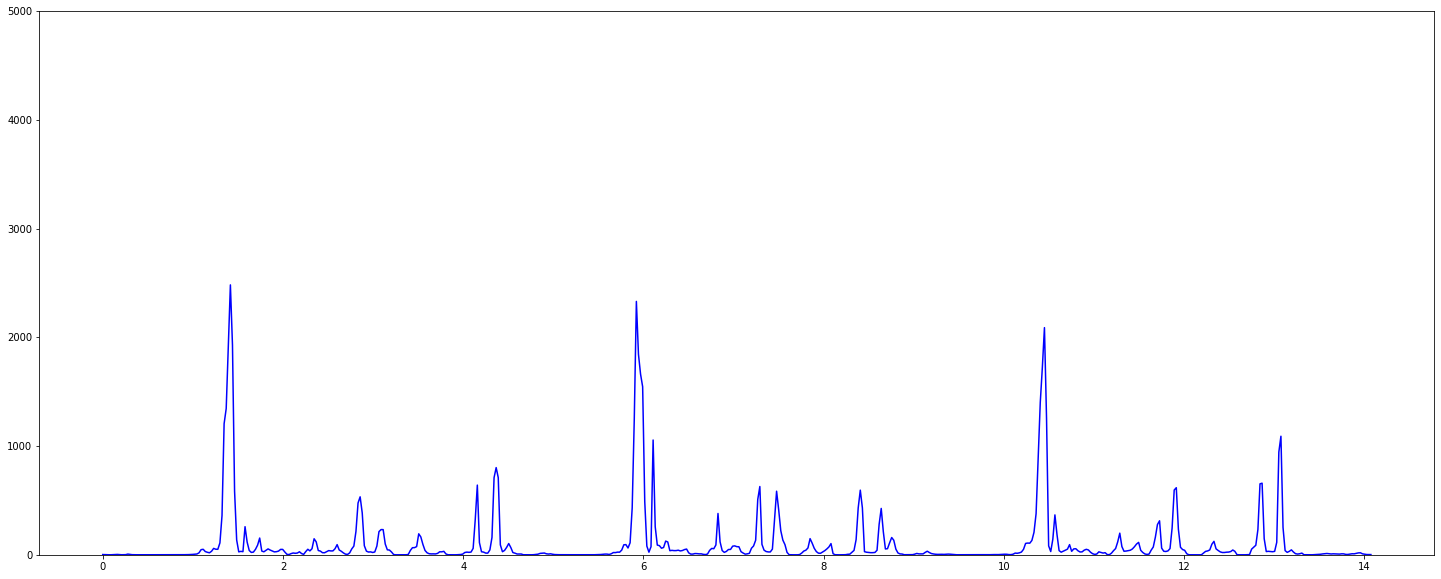

In [92]:
plt.figure(figsize=(25, 10))

plt.plot(t, ber_train_149, color="b")
plt.ylim((0, 5000))
plt.show()

# Spectral centroid with Librosa

In [93]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

In [94]:
sc_train_149 = librosa.feature.spectral_centroid(y=train_149, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [95]:
sc_train_149.shape

(607,)

# Visualising spectral centroid

In [96]:
frames = range(len(sc_train_149))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
len(t)

607

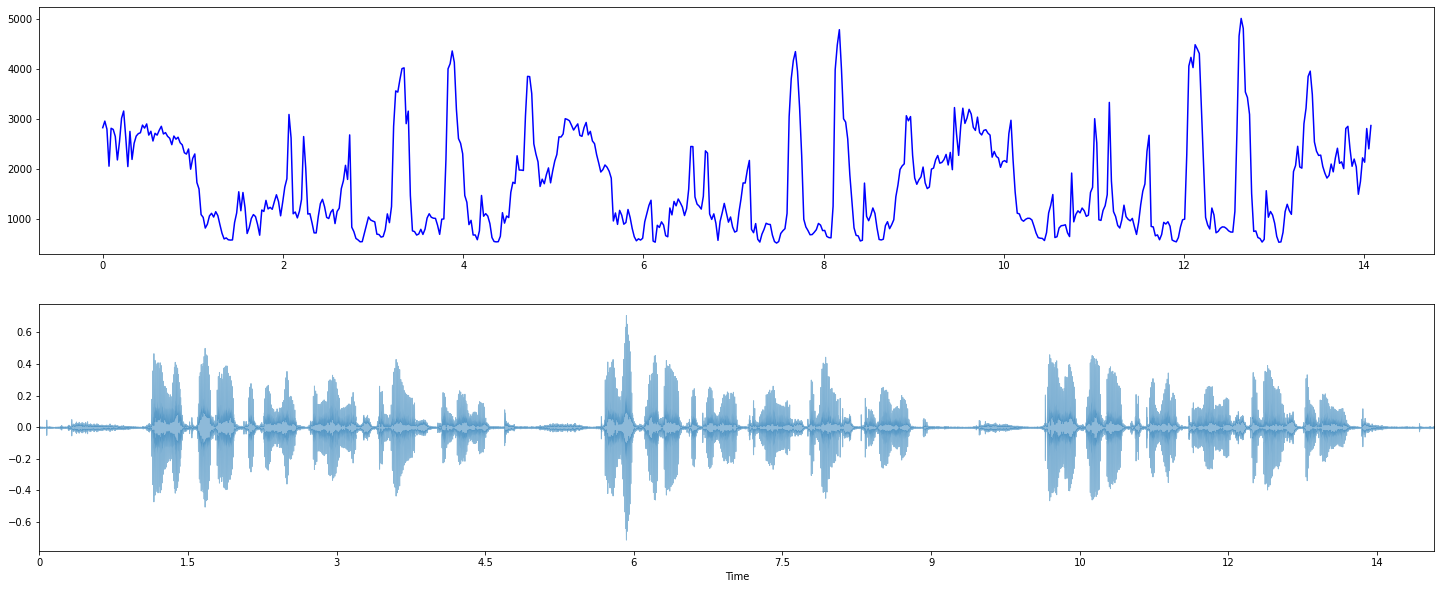

In [104]:
plt.figure(figsize=(25,10))
plt.subplot(2,1,1)

plt.plot(t, sc_train_149, color='b')

plt.subplot(2,1,2)
librosa.display.waveplot(train_149,alpha=0.5)
plt.show()

# Spectral bandwidth with Librosa


In [106]:
ban_train_149 = librosa.feature.spectral_bandwidth(y=train_149, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
ban_train_149.shape

(607,)

# Visualising spectral bandwidth


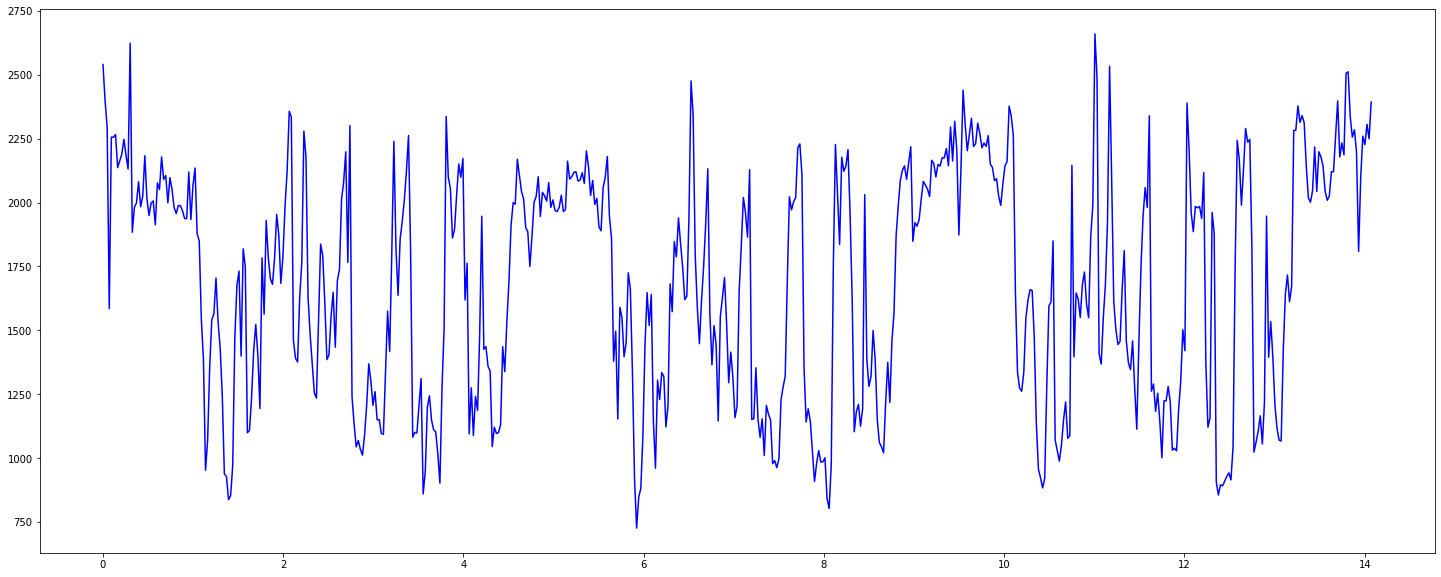

In [107]:
plt.figure(figsize=(25,10))
plt.plot(t, ban_train_149, color='b')
plt.show()